In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import uqer
import numpy as np
import pandas as pd
from uqer import DataAPI as api
from alphamind.api import *
from alphamind.data.neutralize import neutralize

plt.style.use('ggplot')

In [5]:
_ = uqer.Client(token='')

16937@wmcloud.com 账号登录成功


In [6]:
ref_date = '2017-06-23'
factor = 'EPS'

engine = SqlEngine()
universe = Universe('custom', ['zz800'])

# Algorithm Description
--------------------------

猜测的 ``neutralize`` 残差$\bar Res$计算公式：

$$\bar Res_{i,k} = \bar f_{i,k} - \sum_j \beta_{j,k} \times \bar Ex_{i, j, k}$$

其中：$k$为行业分类，$i$为该行业中第$i$只股票，$j$为第$j$个风险因子。$\bar f$为因子序列，$\bar Ex$为风险暴露矩阵。系数$\beta_{j,k}$由OLS确定。

下面的章节，我们分别比较三种``neutralize``的方法差别：

* **UQER Neutralize**

    使用优矿的SDK计算因子残差。


* **Alpha-Mind Neutralize**

    使用alpha-mind计算因子残差，alpha-mind可以由以下地址安装：
    
    ```
    https://github.com/wegamekinglc/alpha-mind
    ```

* **Direct Weighted Least Square Fit Implementation**

    直接使用scikit-learn的线性回归功能来计算因子残差。


# Raw Data
---------------------------

In [7]:
codes = engine.fetch_codes(ref_date, universe)
factor_data = engine.fetch_factor(ref_date, factor, codes)
risk_cov, risk_expousre = engine.fetch_risk_model(ref_date, codes)
total_data = pd.merge(factor_data, risk_expousre, on=['code']).dropna()

In [8]:
total_data['ticker'] = total_data.code.apply(lambda x: '{0:06}'.format(x))
total_data.set_index('ticker', inplace=True)

In [9]:
len(total_data)

800

# UQER Neutralize
-----------------------

In [32]:
%%timeit
neutralized_factor_uqer = uqer.neutralize(total_data[factor],
                                          target_date=ref_date.replace('-', ''),
                                          industry_type='short')

128 ms ± 4.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [33]:
neutralized_factor_uqer = uqer.neutralize(total_data[factor],
                                          target_date=ref_date.replace('-', ''),
                                          industry_type='short')
df = pd.DataFrame(neutralized_factor_uqer, columns=['uqer'])
df.head(10)

,uqer
000001,-0.076975
000002,-0.288382
000006,-0.054668
000008,-0.034123
000009,0.029815
000012,0.089305
000021,0.034998
000025,-0.048613
000027,-0.003274
000028,0.347669


In [34]:
len(neutralized_factor_uqer)

800

In [35]:
risk_exposure_uqer = uqer.DataAPI.RMExposureDayGet(tradeDate=ref_date.replace('-', '')).set_index('ticker')
targeted_secs = risk_exposure_uqer.loc[neutralized_factor_uqer.index]

style_exposure = neutralized_factor_uqer.values @ targeted_secs[risk_styles].values
industry_exposure = neutralized_factor_uqer.values @ targeted_secs[industry_styles].values

exposure = pd.Series(np.concatenate([style_exposure, industry_exposure]), index=risk_styles+industry_styles)
exposure

BETA              6.017409e-14
MOMENTUM          7.993606e-15
SIZE             -6.938894e-14
EARNYILD         -1.829648e-13
RESVOL            2.109424e-13
GROWTH           -1.021405e-13
BTOP             -1.425526e-13
LEVERAGE         -1.541545e-13
LIQUIDTY          4.973799e-14
SIZENL            5.417888e-14
Bank             -8.770762e-15
RealEstate       -1.076916e-14
Health           -6.661338e-16
Transportation    3.774758e-15
Mining           -4.551914e-15
NonFerMetal       9.020562e-15
HouseApp         -4.218847e-15
LeiService       -4.163336e-16
MachiEquip        2.395306e-14
BuildDeco         9.547918e-15
CommeTrade        5.884182e-15
CONMAT            7.188694e-15
Auto              6.883383e-15
Textile           4.996004e-15
FoodBever        -6.217249e-15
Electronics       1.132427e-14
Computer          8.604228e-15
LightIndus        1.346145e-15
Utilities        -6.258882e-15
Telecom           3.608225e-16
AgriForest        8.160139e-15
CHEM             -6.994405e-15
Media   

# Alpha-Mind Neutralize
--------------------------

In [36]:
x = total_data[risk_styles + industry_styles].values
y = total_data[factor].values

In [37]:
%%timeit
neutralized_factor_alphamind = neutralize(x, y, weights=np.ones(len(y)))

139 µs ± 8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [38]:
neutralized_factor_alphamind = neutralize(x, y, weights=np.ones(len(y)))
alphamind_series = pd.Series(neutralized_factor_alphamind.flatten(), index=total_data.index)
df['alpha-mind'] = alphamind_series
df.head()

,uqer,alpha-mind
000001,-0.076975,-0.076975
000002,-0.288382,-0.288382
000006,-0.054668,-0.054668
000008,-0.034123,-0.034123
000009,0.029815,0.029815


In [39]:
len(alphamind_series)

800

# The Ticker Missing in UQER but Still in Alpha-Mind
-----------------------------------

In [40]:
missed_codes = [c for c in alphamind_series.index if c not in neutralized_factor_uqer.index]

In [41]:
total_data.loc[missed_codes]

,code,isOpen,EPS,srisk,BETA,MOMENTUM,SIZE,EARNYILD,RESVOL,GROWTH,...,Telecom,AgriForest,CHEM,Media,IronSteel,NonBankFinan,ELECEQP,AERODEF,Conglomerates,COUNTRY
ticker,,,,,,,,,,,,,,,,,,,,,


# Direct Weighted Least Square Fit Implementation
------------------------

In [42]:
import statsmodels.api as sm

In [43]:
mod = sm.WLS(y, x, weights=np.ones(len(y))).fit()
lg_series = pd.Series(mod.resid, index=total_data.index)

In [44]:
df['ols'] = lg_series

# Comparison
------------------

In [45]:
df['uqer - ols'] = df['uqer'] - df['ols']
df['alphamind - ols'] = df['alpha-mind'] - df['ols']

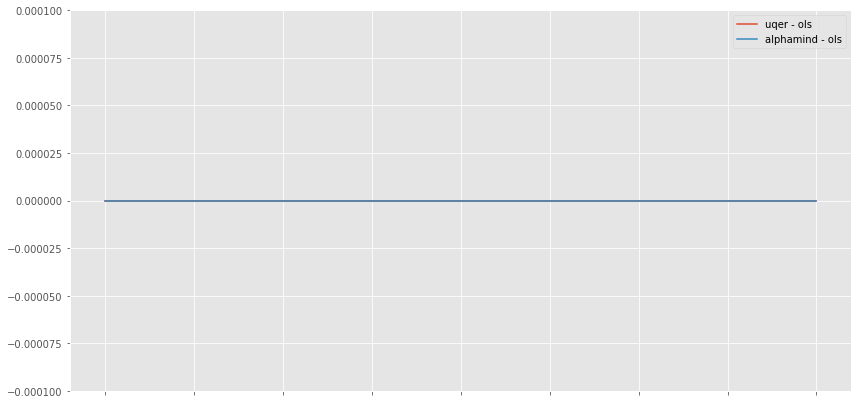

In [46]:
df[['uqer - ols', 'alphamind - ols']].plot(figsize=(14, 7), ylim=(-1e-4, 1e-4))

In [47]:
df.head()

,uqer,alpha-mind,ols,uqer - ols,alphamind - ols
000001,-0.076975,-0.076975,-0.076975,-1.609823e-15,-1.165734e-15
000002,-0.288382,-0.288382,-0.288382,3.885781e-16,-2.220446e-16
000006,-0.054668,-0.054668,-0.054668,8.881784e-16,6.106227e-16
000008,-0.034123,-0.034123,-0.034123,-5.204170e-16,-7.910339e-16
000009,0.029815,0.029815,0.029815,-2.567391e-16,2.775558e-16
